# Algorithms from the Shukla-Vedula Paper

In [1]:
import numpy as np
from scipy.special import lambertw
import math
from qiskit import *
from qiskit.providers.aer import AerSimulator
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

## Walsh functions in the sequency ordering

In [2]:
def walsh_sequency(k, x):
    if k == 0:
        out = np.zeros_like(x)
        for i in range(len(x)):
            if x[k] >= 0 and x[i] <= 1:
                out[k] = 1
        return out
    else:
        if k%2 == 0 and k != 0:
            j = int(k/2)
            return walsh_sequency(j, 2*x) + (-1)**j*walsh_sequency(j, 2*x - 1)
        else:
            j = int((k - 1)/2)
            return walsh_sequency(j, 2*x) - (-1)**j*walsh_sequency(j, 2*x - 1)

## Walsh functions in the natural ordering


In [3]:
def chi(k, x):
        k_bin = format(k, 'b')
        x_bin = format(x, 'b')
        n = min(len(k_bin), len(x_bin))
        summed = 0
        for i in range(n):
            summed += int(k_bin[-1 - i])*int(x_bin[-1 - i])
        return (-1)**summed

def walsh_natural(N, k, x): 
    n = math.log(N, 2)
    if not n.is_integer():
        raise Exception('Length of A must be a power of 2.') 
    out = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] == 1:
            out[i] = chi(k, N - 1) 
        else:
            j = int(x[i]*N)
            out[i] = chi(k, j)
    return out

## Algorithm 1

In [4]:
def HQ(A, eps=1):
    N = len(A)
    n = math.log(N, 2)
    if not n.is_integer():
        raise Exception('Length of A must be a power of 2.')
    n = int(n)

    b0 = eps + np.sum(np.abs(A))
    A_til = np.concatenate((np.array([b0]), A[1:]))
    c = np.linalg.norm(A_til, ord=2)
    circ = QuantumCircuit(n)
    circ.prepare_state(A_til/c)
    for i in range(n):
        circ.h(i)
    circ.measure_all()

    backend = AerSimulator(method='statevector', device='GPU')
    shots = 1000000
    circ = transpile(circ, backend, optimization_level=0)
    counts = backend.run(circ, shots=shots).result().get_counts()

    delta = 1/np.sqrt(N)*(b0 - A[0])
    out = np.empty(N)
    for i in range(N):
        bitstring = format(i, 'b')
        if len(bitstring) < n:
            bitstring = ''.join('0' for i in range(n - len(bitstring))) + bitstring
        out[i] = c*np.sqrt(counts.get(bitstring, 0)/shots) - delta
    return out

## Testing the results so far

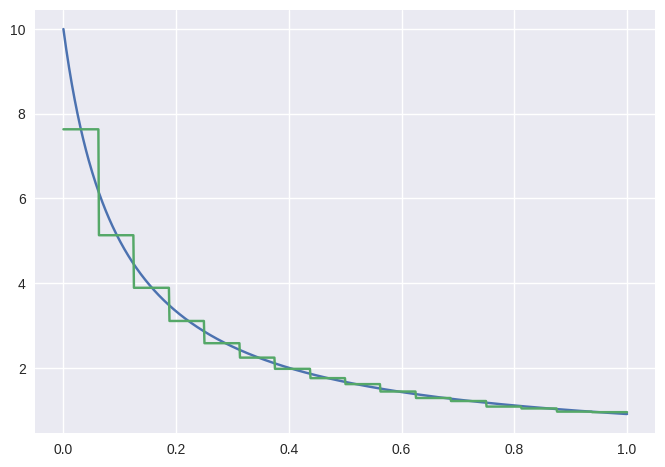

In [5]:
n = 4
N = 2**n
f = lambda x: 1/(x + .1)
A = f(np.array([i/2/N for i in range(1, 2*N, 2)]))
coeffs = HQ(A)

x = np.linspace(0, 1, 1000)
plt.plot(x, f(x))
plt.plot(x, sum([1/np.sqrt(N)*coeffs[k]*walsh_natural(N, k, x) for k in range(N)]))
plt.show()

## Code to initialize the integration matrix

In [6]:
def integration_matrix(N):
    n = math.log(N, 2)
    if not n.is_integer():
        raise Exception('Length of A must be a power of 2.')
    n = int(n)
    I = np.zeros((N, N))
    I[0, 0] = 1/2
    for r in range(1, n + 1):
        for m in range(2**(n - r)):
            i, j = m*2**r, m*2**r + 2**(r - 1)
            I[i, j] = 1/2**(n - r + 2)
            I[j, i] = -1/2**(n - r + 2)
    return I

## Algorithm 2

In [7]:
def diff_eq_solver(N, tol, f_list, x_init, grid, analytical, maxiter=30):
    def update():
        x = x_init.copy()
        coeffs_init = np.array([HQ(row) for row in x_init])
        coeffs = coeffs_init.copy()
        I = integration_matrix(N)
        fig = plt.figure()
        hfig = display(fig, display_id=True, clear=True)
        counter = 0
        while True:
            new_coeffs = np.array([row + I@HQ(f(x)) for row, f in zip(coeffs_init, f_list)])
            x = np.array([HQ(row) for row in new_coeffs])
            update = np.linalg.norm(new_coeffs - coeffs) 
            coeffs = new_coeffs.copy()
            counter += 1

            plt.clf()
            for i in range(len(f_list)):
                ax = fig.add_subplot(len(f_list), 1, i + 1)
                ax.plot(grid, sum([1/np.sqrt(N)*coeffs[i][k]*walsh_natural(N, k, grid) for k in range(N)]))
                if len(f_list) > 1:
                    ax.set_title(fr'$x_{i}$')
                ax.plot(grid, analytical[i](grid))
            plt.suptitle(str(counter) + ' iterations, update = ' + str(round(update, 4)))
            plt.tight_layout()
            fig.canvas.draw()
            hfig.update(fig)

            if update < tol*len(f_list) and counter >= 5:
                break
            if counter >= maxiter:
                break
        plt.close(fig)
        return new_coeffs
    coeffs = update()
    return coeffs

## Riccati example

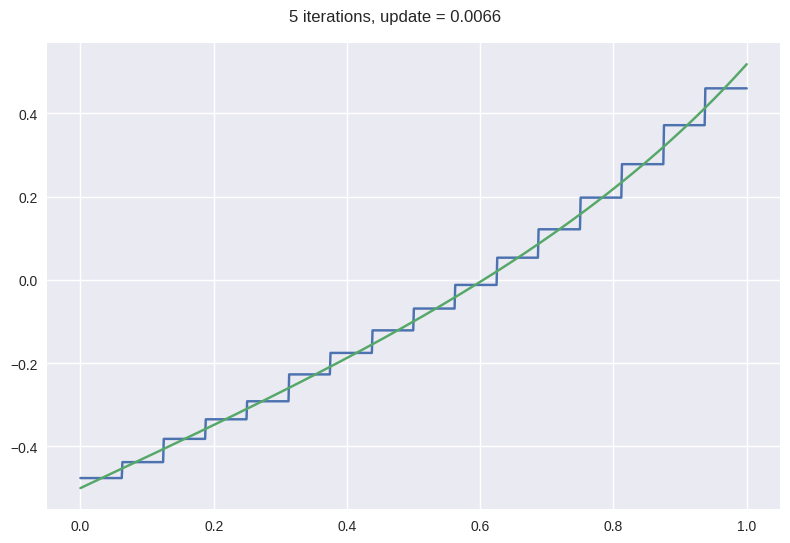

In [8]:
N = 2**4
tol = 1e-2
grid = np.linspace(0, 1, 1000)
analytical = lambda x: 1/2*(np.sqrt(3)*np.tan(np.sqrt(3)*x/2) - 1)
coeffs = diff_eq_solver(N, tol, f_list = [lambda x: (x**2 + x + 1).ravel()], x_init = -1/2*np.ones(N).reshape(1, -1), grid=grid, analytical=[analytical])

## Stiff example

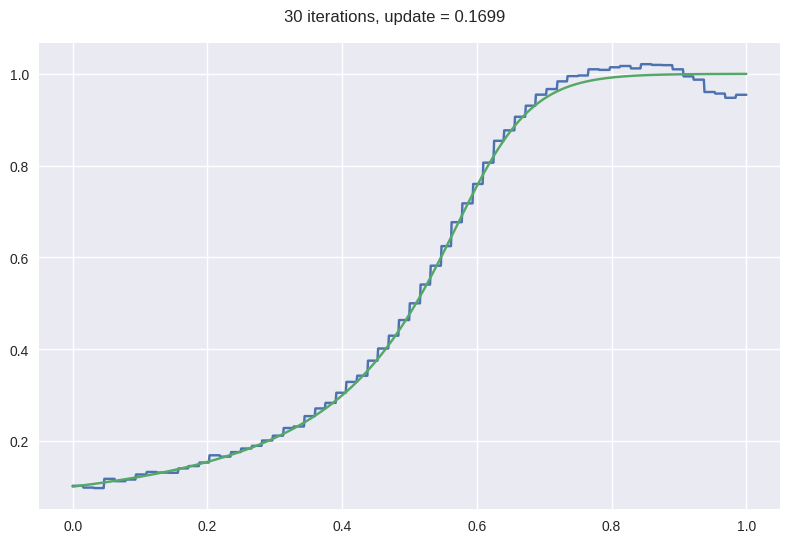

In [10]:
N = 2**6
tol = 1e-2
delta = .1
grid = np.linspace(0, 1, 1000)
f = lambda x: np.ravel(2/delta*x**2*(1 - x))
x_init = delta*np.ones(N).reshape(1, -1)
a = 1/delta - 1
analytical = lambda x: np.real(1/(lambertw(a*np.exp(a - (2*x/delta)), k=0) + 1))
coeffs = diff_eq_solver(N, tol, [f], x_init, grid=grid, analytical=[analytical])

## System example

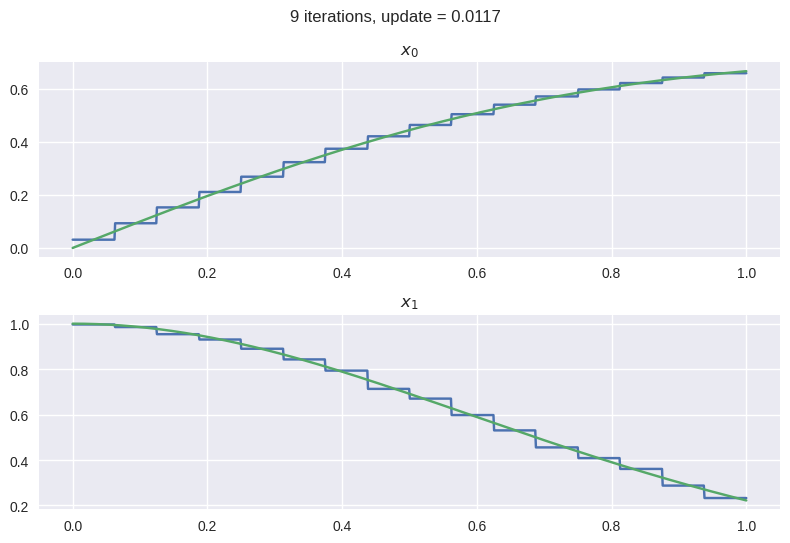

In [11]:
N = 2**4
tol = 1e-2
grid = np.linspace(0, 1, 1000)
f1 = lambda x: x[1]
f2 = lambda x: -(3*x[0]*x[1] + x[0]**3) 
x_init = np.vstack((np.zeros(N), np.ones(N)))
analytical1 = lambda x: 2*x/(x**2 + 2)
analytical2 = lambda x: (4*(np.sqrt((x**2 - 2)**2/(x**2 + 2)**2) - 1)*x**2 + 4*np.sqrt((x**2 - 2)**2/(x**2 + 2)**2) + (np.sqrt((x**2 - 2)**2/(x**2 + 2)**2) + 1)*x**4 + 4)/(2*(x**2 + 2)**2)
coeffs = diff_eq_solver(N, tol, [f1, f2], x_init, grid, [analytical1, analytical2])